In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import import_ipynb
import Captcha_seg
import time

importing Jupyter notebook from Captcha_seg.ipynb


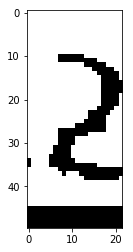

In [2]:
SEGMENTS_DIR = 'Segmented'
CAPTCHA_DIR = 'CAPTCHAS'
predictions = []
b_captcha = []

DATADIR = "./captcha_segmented/"
CATEGORIES= ["2","3","4","5","6","7","8","b","c","d","e","f","g","m","n","p","w","x","y"]
for category in CATEGORIES:
    path = os.path.join(DATADIR, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
        plt.imshow(img_array, cmap="gray")
        break
    break

In [3]:
print(img_array.shape)

(50, 22)


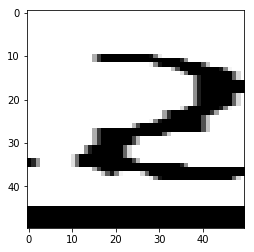

In [4]:
IMG_SIZE = 50

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap= 'gray')
plt.show()

In [5]:
train_data = []

def create_train_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category) 
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                train_data.append([new_array,class_num])
            except Exception as e:
                pass
            
create_train_data()

In [6]:
print(len(train_data))

3420


In [7]:
import random

random.shuffle(train_data)

In [8]:
for sample in train_data[:10]:
    print(sample[1])

11
15
15
8
18
14
10
4
0
13


In [9]:
X = []
y = []

In [10]:
for features, label in train_data:
    X.append(features)
    y.append(label)
    
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

In [11]:
import pickle

pickle_out = open("X.pickle", "wb")
pickle.dump(X, pickle_out)
pickle_out.close()
pickle_out = open("y.pickle", "wb")
pickle.dump(y, pickle_out)
pickle_out.close()

In [12]:
pickle_in= open("X.pickle", "rb")
X = pickle.load(pickle_in)
X.shape[1:]

(50, 50, 1)

In [13]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout,Activation, Flatten, Conv2D, MaxPooling2D

X = pickle.load(open("X.pickle","rb"))
y = pickle.load(open("y.pickle","rb"))

X = X/255.0

model = Sequential()

model.add(Conv2D(64,(3,3),input_shape= X.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation("relu"))


model.add(Dense(19))
model.add(Activation("softmax"))

from keras.utils import to_categorical
y_binary = to_categorical(y)

model.compile(loss="categorical_crossentropy",
             optimizer="adam",
             metrics=['accuracy'])

model.fit(X,y_binary,batch_size=128, epochs=10, validation_split = 0.2)


Using TensorFlow backend.


Train on 2736 samples, validate on 684 samples
Epoch 1/10
2736/2736 [==============================] - 8s 3ms/step - loss: 2.7919 - acc: 0.1743 - val_loss: 2.2437 - val_acc: 0.3772
Epoch 2/10
2736/2736 [==============================] - 8s 3ms/step - loss: 1.5015 - acc: 0.5771 - val_loss: 0.9730 - val_acc: 0.7471
Epoch 3/10
2736/2736 [==============================] - 8s 3ms/step - loss: 0.8444 - acc: 0.7752 - val_loss: 0.6699 - val_acc: 0.8231
Epoch 4/10
2736/2736 [==============================] - 8s 3ms/step - loss: 0.6161 - acc: 0.8322 - val_loss: 0.5222 - val_acc: 0.8699
Epoch 5/10
2736/2736 [==============================] - 8s 3ms/step - loss: 0.5009 - acc: 0.8681 - val_loss: 0.5213 - val_acc: 0.8626
Epoch 6/10
2736/2736 [==============================] - 8s 3ms/step - loss: 0.4148 - acc: 0.8830 - val_loss: 0.4077 - val_acc: 0.9020
Epoch 7/10
2736/2736 [==============================] - 8s 3ms/step - loss: 0.3516 - acc: 0.9028 - val_loss: 0.3692 - val_acc: 0.9035
Epoch 8/10
2736

In [14]:
loss_value, metrics_value = model.evaluate(X,y_binary,batch_size=10)

3420/3420 [==============================] - 3s 975us/step


In [15]:
print(loss_value, metrics_value)

0.19390137419540282 0.9423976542308317


In [16]:
def similarity(a,b):
    i =0
    for x,y in zip(a,b):
        if x==y:
            i+= 1
    percentage = (i/5) * 100
    return percentage

def prepare(filepath):
    IMG_SIZE = 50
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    new_array = cv2.resize(img_array, (IMG_SIZE,IMG_SIZE))
    #plt.imshow(new_array,'gray')
    return new_array.reshape(-1, IMG_SIZE,IMG_SIZE,1)

total_time = 0
score = 0
count = 0
for captchas in os.listdir(CAPTCHA_DIR):
    start_time = time.time()
    predict_list= []
    captcha_name = captchas.split('.')
    print('\n')
    print('Actual: ',captcha_name[0])
    
    captcha_path =os.path.join(CAPTCHA_DIR,captchas)
    Captcha_seg.segment(captcha_path)
    
    files = []
    for segments in os.listdir(SEGMENTS_DIR):
        files.append(segments)
        files.sort()
    
    for segments in files:
        filepath = os.path.join(SEGMENTS_DIR,segments)
        prediction = model.predict([prepare(filepath)])
        predict_list.append(CATEGORIES[np.argmax(prediction[0])])
    
    elapsed_time = time.time()-start_time
    total_time += elapsed_time
    final_prediction = ''.join(predict_list)
    if captcha_name[0]== final_prediction:
        score +=1
    
    print('Predicted:',final_prediction,'\n')
    print('Percentage Similarity= ',similarity(captcha_name[0],final_prediction))
    print('Elapsed time= ',elapsed_time,'s')
    print('<------------------------------->')    
    predictions.append(similarity(captcha_name[0],final_prediction))
    count += 1


print('Total number of CAPTCHAS broken: ',score)    
print('Total number of CAPTCHAS attempted: ',count)
avg_prediction = score/count
print('Average Characters Predicted= ',avg_prediction,'%')
print('Total time taken= ',total_time,'s')
#model = tf.keras.models.load_model('captcha_alpha.model')
#prediction = model.predict([prepare('3.png')])
#print(len(prediction[0]))
#print(prediction[0])
#print(CATEGORIES[np.argmax(prediction[0])])



Actual:  bgd4m
Predicted: bgd4m 

Percentage Similarity=  100.0
Elapsed time=  0.04348325729370117 s
<------------------------------->


Actual:  6f2yc
Predicted: 6f2yc 

Percentage Similarity=  100.0
Elapsed time=  0.014021158218383789 s
<------------------------------->


Actual:  c7gb3
Predicted: c7gb3 

Percentage Similarity=  100.0
Elapsed time=  0.013824462890625 s
<------------------------------->


Actual:  by5y3
Predicted: by5y3 

Percentage Similarity=  100.0
Elapsed time=  0.014917612075805664 s
<------------------------------->


Actual:  38n57
Predicted: 38n57 

Percentage Similarity=  100.0
Elapsed time=  0.014193296432495117 s
<------------------------------->


Actual:  e43ym
Predicted: e43ym 

Percentage Similarity=  100.0
Elapsed time=  0.014286518096923828 s
<------------------------------->


Actual:  245y5
Predicted: 245y5 

Percentage Similarity=  100.0
Elapsed time=  0.014348268508911133 s
<------------------------------->


Actual:  bdbb3
Predicted: bdbb3 

Pe

Predicted: c3d57 

Percentage Similarity=  40.0
Elapsed time=  0.014257669448852539 s
<------------------------------->


Actual:  226md
Predicted: 226nc 

Percentage Similarity=  60.0
Elapsed time=  0.013534069061279297 s
<------------------------------->


Actual:  d4ppy
Predicted: d4pcy 

Percentage Similarity=  80.0
Elapsed time=  0.01185750961303711 s
<------------------------------->


Actual:  2p2y8
Predicted: 2p2y5 

Percentage Similarity=  80.0
Elapsed time=  0.013575315475463867 s
<------------------------------->


Actual:  3xng6
Predicted: 3xng6 

Percentage Similarity=  100.0
Elapsed time=  0.014001607894897461 s
<------------------------------->


Actual:  cfc56
Predicted: cfc56 

Percentage Similarity=  100.0
Elapsed time=  0.014891386032104492 s
<------------------------------->


Actual:  dmw8n
Predicted: dmw76 

Percentage Similarity=  60.0
Elapsed time=  0.016057729721069336 s
<------------------------------->


Actual:  677g3
Predicted: 677g3 

Percentage Similarity

Predicted: cnex4 

Percentage Similarity=  100.0
Elapsed time=  0.011437177658081055 s
<------------------------------->


Actual:  56c34
Predicted: 56237 

Percentage Similarity=  60.0
Elapsed time=  0.01210927963256836 s
<------------------------------->


Actual:  3nnpw
Predicted: 3nnpw 

Percentage Similarity=  100.0
Elapsed time=  0.011394977569580078 s
<------------------------------->


Actual:  43gey
Predicted: 43gey 

Percentage Similarity=  100.0
Elapsed time=  0.010828018188476562 s
<------------------------------->


Actual:  c2g4d
Predicted: c2g4d 

Percentage Similarity=  100.0
Elapsed time=  0.012001752853393555 s
<------------------------------->


Actual:  785n4
Predicted: 78564 

Percentage Similarity=  80.0
Elapsed time=  0.011236906051635742 s
<------------------------------->


Actual:  b5nmm
Predicted: b5nmn 

Percentage Similarity=  80.0
Elapsed time=  0.011995553970336914 s
<------------------------------->


Actual:  c2yn8
Predicted: c2yn8 

Percentage Similari

Predicted: b4ncn 

Percentage Similarity=  100.0
Elapsed time=  0.011801719665527344 s
<------------------------------->


Actual:  8cm46
Predicted: 8cm46 

Percentage Similarity=  100.0
Elapsed time=  0.011307001113891602 s
<------------------------------->


Actual:  47m2b
Predicted: 47x2b 

Percentage Similarity=  80.0
Elapsed time=  0.011891603469848633 s
<------------------------------->


Actual:  dnne7
Predicted: dnne7 

Percentage Similarity=  100.0
Elapsed time=  0.011305093765258789 s
<------------------------------->


Actual:  dbny3
Predicted: dbny3 

Percentage Similarity=  100.0
Elapsed time=  0.012641191482543945 s
<------------------------------->


Actual:  6xpme
Predicted: 6xpmx 

Percentage Similarity=  80.0
Elapsed time=  0.011153936386108398 s
<------------------------------->


Actual:  bm3p8
Predicted: bm3p8 

Percentage Similarity=  100.0
Elapsed time=  0.011027097702026367 s
<------------------------------->


Actual:  5xd2e
Predicted: 5xd2e 

Percentage Simila

Predicted: 3nfdn 

Percentage Similarity=  100.0
Elapsed time=  0.013048648834228516 s
<------------------------------->


Actual:  76353
Predicted: 76352 

Percentage Similarity=  80.0
Elapsed time=  0.011173486709594727 s
<------------------------------->


Actual:  defyx
Predicted: defyx 

Percentage Similarity=  100.0
Elapsed time=  0.010863065719604492 s
<------------------------------->


Actual:  4b2pw
Predicted: 4b2pw 

Percentage Similarity=  100.0
Elapsed time=  0.0106048583984375 s
<------------------------------->


Actual:  dcnp8
Predicted: dcnp8 

Percentage Similarity=  100.0
Elapsed time=  0.013188600540161133 s
<------------------------------->


Actual:  cc845
Predicted: cc845 

Percentage Similarity=  100.0
Elapsed time=  0.01207113265991211 s
<------------------------------->


Actual:  dw3nn
Predicted: dw3mn 

Percentage Similarity=  80.0
Elapsed time=  0.01298069953918457 s
<------------------------------->


Actual:  5bnd7
Predicted: 5bnd7 

Percentage Similarity

Predicted: d22y5 

Percentage Similarity=  100.0
Elapsed time=  0.014071226119995117 s
<------------------------------->


Actual:  dbpcd
Predicted: dbpcd 

Percentage Similarity=  100.0
Elapsed time=  0.012656211853027344 s
<------------------------------->


Actual:  3nw7w
Predicted: 3nw7w 

Percentage Similarity=  100.0
Elapsed time=  0.011938333511352539 s
<------------------------------->


Actual:  efg72
Predicted: efg72 

Percentage Similarity=  100.0
Elapsed time=  0.011516809463500977 s
<------------------------------->


Actual:  5g5e5
Predicted: 5g5e5 

Percentage Similarity=  100.0
Elapsed time=  0.012724876403808594 s
<------------------------------->


Actual:  bw5ym
Predicted: bw7ym 

Percentage Similarity=  80.0
Elapsed time=  0.014120817184448242 s
<------------------------------->


Actual:  6ydyp
Predicted: 6ydyp 

Percentage Similarity=  100.0
Elapsed time=  0.011691093444824219 s
<------------------------------->


Actual:  7wn74
Predicted: 7wn74 

Percentage Simil

Predicted: 2wc78 

Percentage Similarity=  80.0
Elapsed time=  0.01165151596069336 s
<------------------------------->


Actual:  3n3cf
Predicted: 3n3cf 

Percentage Similarity=  100.0
Elapsed time=  0.011602640151977539 s
<------------------------------->


Actual:  5mfff
Predicted: 5nfff 

Percentage Similarity=  80.0
Elapsed time=  0.012417078018188477 s
<------------------------------->


Actual:  4n2yg
Predicted: 4n2yg 

Percentage Similarity=  100.0
Elapsed time=  0.013072729110717773 s
<------------------------------->


Actual:  74853
Predicted: 74853 

Percentage Similarity=  100.0
Elapsed time=  0.012784957885742188 s
<------------------------------->


Actual:  478nx
Predicted: 478nx 

Percentage Similarity=  100.0
Elapsed time=  0.01192021369934082 s
<------------------------------->


Actual:  6ecbn
Predicted: 6ecbn 

Percentage Similarity=  100.0
Elapsed time=  0.011303186416625977 s
<------------------------------->


Actual:  4exnn
Predicted: 4exmn 

Percentage Similari

Predicted: 3xcgg 

Percentage Similarity=  100.0
Elapsed time=  0.011962413787841797 s
<------------------------------->


Actual:  6end3
Predicted: 6end3 

Percentage Similarity=  100.0
Elapsed time=  0.012746810913085938 s
<------------------------------->


Actual:  646x8
Predicted: 646x8 

Percentage Similarity=  100.0
Elapsed time=  0.011778116226196289 s
<------------------------------->


Actual:  467d5
Predicted: 467d5 

Percentage Similarity=  100.0
Elapsed time=  0.011696338653564453 s
<------------------------------->


Actual:  368y5
Predicted: 368y5 

Percentage Similarity=  100.0
Elapsed time=  0.011220693588256836 s
<------------------------------->


Actual:  4c8n8
Predicted: 4c8e5 

Percentage Similarity=  60.0
Elapsed time=  0.011766195297241211 s
<------------------------------->


Actual:  egxmp
Predicted: egxmp 

Percentage Similarity=  100.0
Elapsed time=  0.010736465454101562 s
<------------------------------->


Actual:  6f857
Predicted: 6f857 

Percentage Simil

Predicted: 25w53 

Percentage Similarity=  100.0
Elapsed time=  0.0121002197265625 s
<------------------------------->


Actual:  373gb
Predicted: 373gx 

Percentage Similarity=  80.0
Elapsed time=  0.011997699737548828 s
<------------------------------->


Actual:  7cdge
Predicted: 7cdge 

Percentage Similarity=  100.0
Elapsed time=  0.011995077133178711 s
<------------------------------->


Actual:  8bbm4
Predicted: 8bbc4 

Percentage Similarity=  80.0
Elapsed time=  0.0143280029296875 s
<------------------------------->


Actual:  58b5m
Predicted: 58b5m 

Percentage Similarity=  100.0
Elapsed time=  0.012104511260986328 s
<------------------------------->


Actual:  5nnff
Predicted: 5nnff 

Percentage Similarity=  100.0
Elapsed time=  0.011442899703979492 s
<------------------------------->


Actual:  d7en3
Predicted: d7en3 

Percentage Similarity=  100.0
Elapsed time=  0.011168956756591797 s
<------------------------------->


Actual:  d3ycn
Predicted: d3ycn 

Percentage Similarity

Predicted: 566cx 

Percentage Similarity=  80.0
Elapsed time=  0.01213693618774414 s
<------------------------------->


Actual:  ec6pm
Predicted: ec6pm 

Percentage Similarity=  100.0
Elapsed time=  0.01194000244140625 s
<------------------------------->


Actual:  8n5pn
Predicted: 8n5pn 

Percentage Similarity=  100.0
Elapsed time=  0.012037038803100586 s
<------------------------------->


Actual:  3ym7f
Predicted: 3yn7f 

Percentage Similarity=  80.0
Elapsed time=  0.011948823928833008 s
<------------------------------->


Actual:  5ywwf
Predicted: 5ywxf 

Percentage Similarity=  80.0
Elapsed time=  0.011284828186035156 s
<------------------------------->


Actual:  5f3gf
Predicted: 5f2ff 

Percentage Similarity=  60.0
Elapsed time=  0.011980533599853516 s
<------------------------------->


Actual:  7fde7
Predicted: 7fdx7 

Percentage Similarity=  80.0
Elapsed time=  0.01114654541015625 s
<------------------------------->


Actual:  dgcm4
Predicted: dgcn4 

Percentage Similarity= 